Open-Meteo API

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Function to fetch daily max temperatures from Open-Meteo API
def get_temperature_data(city_name, latitude, longitude, year):
    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={latitude}"
        f"&longitude={longitude}"
        f"&start_date={year}-01-01"
        f"&end_date={year}-12-31"
        f"&daily=temperature_2m_max"
        f"&timezone=Europe%2FBerlin"
    )

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        dates = data['daily']['time']
        temps = data['daily']['temperature_2m_max']
        return {
            "city": city_name,
            "year": year,
            "dates": dates,
            "temperatures": temps
        }
    else:
        print("Failed to retrieve data:", response.status_code)
        return None

Load data & convert to DataFrame

In [2]:
# City names and coordinates
cities = {
    "Zurich": (47.3769, 8.5417),
    "Lugano": (46.0037, 8.9511),
    "Geneva": (46.2044, 6.1432)
}

years = list(range(2014, 2024))  # 2014–2023

all_daily_records = []

# Loop through all cities and years
for city, (lat, lon) in cities.items():
    for year in years:
        print(f"Fetching data for {city}, {year}...")
        result = get_temperature_data(city, lat, lon, year)
        if result:
            for date, temp in zip(result["dates"], result["temperatures"]):
                all_daily_records.append({
                    "City": result["city"],
                    "Date": date,
                    "Year": result["year"],
                    "MaxTemp": temp
                })

# Convert to DataFrame
df_daily = pd.DataFrame(all_daily_records)
df_daily["Date"] = pd.to_datetime(df_daily["Date"])

# Calculate yearly averages
df_yearly = df_daily.groupby(["City", "Year"])["MaxTemp"].mean().reset_index()
df_yearly.rename(columns={"MaxTemp": "AvgMaxTemp"}, inplace=True)

# Show samples
print(df_daily.head())
print(df_yearly.head())


Fetching data for Zurich, 2014...
Fetching data for Zurich, 2015...
Fetching data for Zurich, 2016...
Fetching data for Zurich, 2017...
Fetching data for Zurich, 2018...
Fetching data for Zurich, 2019...
Fetching data for Zurich, 2020...
Fetching data for Zurich, 2021...
Fetching data for Zurich, 2022...
Fetching data for Zurich, 2023...
Fetching data for Lugano, 2014...
Fetching data for Lugano, 2015...
Fetching data for Lugano, 2016...
Fetching data for Lugano, 2017...
Fetching data for Lugano, 2018...
Fetching data for Lugano, 2019...
Fetching data for Lugano, 2020...
Fetching data for Lugano, 2021...
Fetching data for Lugano, 2022...
Fetching data for Lugano, 2023...
Fetching data for Geneva, 2014...
Fetching data for Geneva, 2015...
Fetching data for Geneva, 2016...
Fetching data for Geneva, 2017...
Fetching data for Geneva, 2018...
Fetching data for Geneva, 2019...
Fetching data for Geneva, 2020...
Fetching data for Geneva, 2021...
Fetching data for Geneva, 2022...
Fetching data 

Mean value of each city

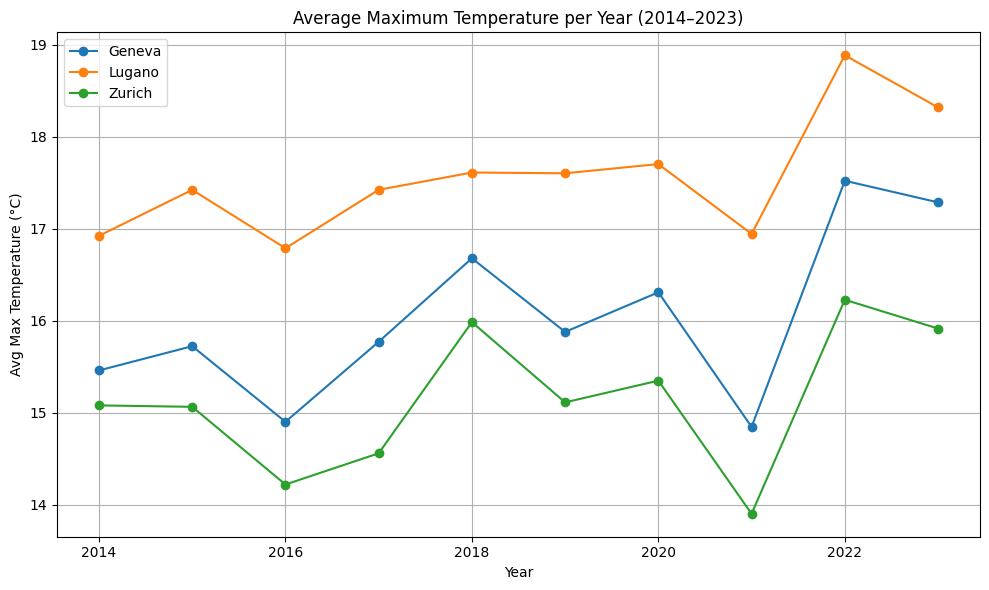

In [3]:
plt.figure(figsize=(10, 6))

for city in df_yearly["City"].unique():
    subset = df_yearly[df_yearly["City"] == city]
    plt.plot(subset["Year"], subset["AvgMaxTemp"], marker="o", label=city)

plt.title("Average Maximum Temperature per Year (2014–2023)")
plt.xlabel("Year")
plt.ylabel("Avg Max Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Max temperature per city - visualised

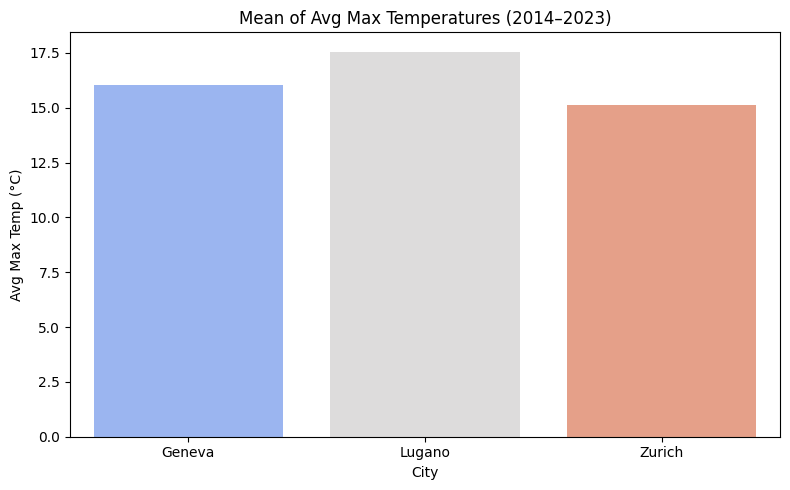

In [4]:
avg_per_city = df_yearly.groupby("City")["AvgMaxTemp"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_per_city, x="City", y="AvgMaxTemp", hue="City", palette="coolwarm", legend=False)

plt.title("Mean of Avg Max Temperatures (2014–2023)")
plt.ylabel("Avg Max Temp (°C)")
plt.xlabel("City")
plt.tight_layout()
plt.show()


Statistical Test

In [5]:
zurich = df_yearly[df_yearly["City"] == "Zurich"]["AvgMaxTemp"]
lugano = df_yearly[df_yearly["City"] == "Lugano"]["AvgMaxTemp"]

t_stat, p_value = ttest_ind(zurich, lugano, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Statistically significant difference between Zurich and Lugano.")
else:
    print("❌ No statistically significant difference.")


T-statistic: -7.634
P-value: 0.0000
✅ Statistically significant difference between Zurich and Lugano.


Heatmap

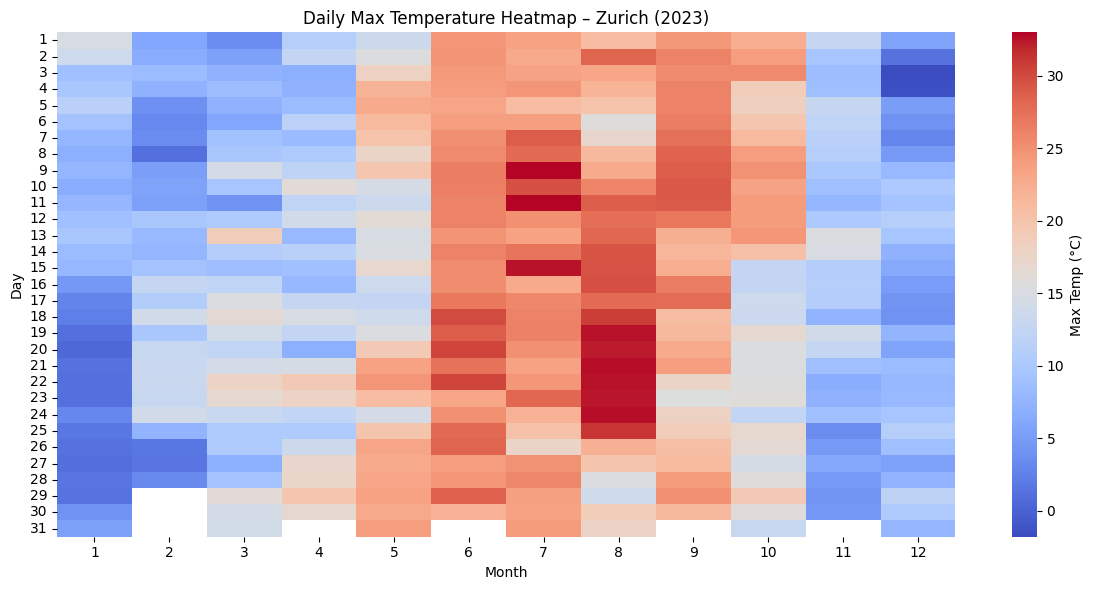

In [6]:
# Filter data for one city and year
city = "Zurich"
year = 2023
df_heat = df_daily[(df_daily["City"] == city) & (df_daily["Year"] == year)].copy()

# Extract month and day
df_heat["Month"] = df_heat["Date"].dt.month
df_heat["Day"] = df_heat["Date"].dt.day

# Pivot to day × month matrix
pivot = df_heat.pivot_table(index="Day", columns="Month", values="MaxTemp")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=False, cbar_kws={'label': 'Max Temp (°C)'})
plt.title(f"Daily Max Temperature Heatmap – {city} ({year})")
plt.xlabel("Month")
plt.ylabel("Day")
plt.tight_layout()
plt.show()


SQL Queries

In [7]:
import sqlite3

# Save df_yearly to SQLite
conn = sqlite3.connect("climate_data.db")
df_yearly.to_sql("avg_temperatures", conn, if_exists="replace", index=False)

# Example SQL query: get average temp per city, descending
query = """
SELECT City, AVG(AvgMaxTemp) as MeanTemp
FROM avg_temperatures
GROUP BY City
ORDER BY MeanTemp DESC
"""
sql_result = pd.read_sql_query(query, conn)
print(sql_result)

# Don't forget to close the connection
conn.close()

     City   MeanTemp
0  Lugano  17.563509
1  Geneva  16.038298
2  Zurich  15.141625


ollama LLM

In [3]:
from transformers import pipeline
from huggingface_hub import login
import os
from dotenv import load_dotenv

load_dotenv()
login(os.getenv("HF_API_KEY"))

summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

text = """
From 2014 to 2023, global CO2 concentrations increased from 400ppm to 418ppm. 
Average global temperature anomalies rose from +0.7°C to +1.1°C, indicating accelerated warming.
Arctic ice coverage shrank, sea levels rose, and extreme weather events became more frequent.
"""

summary = summarizer(text, max_length=60, min_length=20, do_sample=False)
print("\nSUMMARY:\n", summary[0]["summary_text"])


Device set to use cpu



SUMMARY:
  Average global temperature anomalies rose from +0.7°C to +1.1°C, indicating accelerated warming . Arctic ice coverage shrank, sea levels rose, and extreme weather events became more frequent .
